In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, roc_auc_score
import time

## Feature pre-processing

In [2]:
# Load the cleaned dataset
df = pd.read_csv('cleaned_df.csv', index_col=0)
df.head()

,age,workclass,education_num,marital_status,occupation,race,sex,hours_per_week,native_country,target
0,39,State-gov,13,Never-married,Adm-clerical,White,Male,40,US,<=50K
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,White,Male,13,US,<=50K
2,38,Private,9,Divorced,Handlers-cleaners,White,Male,40,US,<=50K
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Black,Male,40,US,<=50K
4,28,Private,13,Married-civ-spouse,Prof-specialty,Black,Female,40,Other_Americans,<=50K


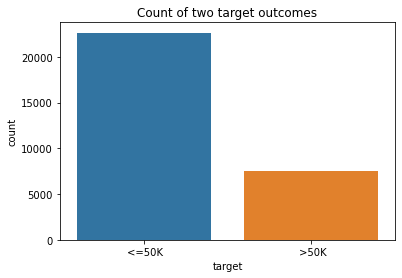

In [4]:
sns.countplot(x=df['target'])
plt.title('Count of two target outcomes')
plt.show()

In [5]:
# Convert the categorical variables into numbers
df['sex'] = df['sex'].map({' Male':0, ' Female':1})
df['target'] = df['target'].map({' <=50K':0, ' >50K':1})
df = pd.get_dummies(df, drop_first=True)

In [6]:
df.head()

,age,education_num,sex,hours_per_week,target,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,native_country_EU,native_country_Other_Americans,native_country_US
0,39,13,0,40,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
1,50,13,0,13,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
2,38,9,0,40,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,53,7,0,40,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,28,13,1,40,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [7]:
# Assign the target/feature
# Split into training set and testing set
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model building

In [9]:
# Create a function to evaluate the model performance later. 
def class_metrics(model, x_data, y_data):
    y_pred = model.predict(x_data)
    print(classification_report(y_data, y_pred, target_names=['<=50K', '>50K']), end='\n')
    
    tn,fp,fn,tp = confusion_matrix(y_data, y_pred).ravel()
    print(pd.DataFrame({'Actual <=50K':[tn,fp], 'Actual >50K':[fn,tp]}, 
                       index=['Predict <=50K', 'Predict >50K'])/len(x_data))

### Logistic Regression

In [77]:
# Training by default setting
log = LogisticRegression(class_weight='balanced')

t1 = time.time()
log.fit(X_train_scaled, y_train)

print('Training performance:')
class_metrics(log, X_train_scaled, y_train)

print('\n\nTesting performance:')
class_metrics(log, X_test_scaled, y_test)
t2 = time.time()

print('\n')
print(f'Time spent: {round(t2-t1, 2)}s')

Training performance:
              precision    recall  f1-score   support

       <=50K       0.93      0.77      0.85     18148
        >50K       0.55      0.83      0.66      5963

    accuracy                           0.79     24111
   macro avg       0.74      0.80      0.75     24111
weighted avg       0.84      0.79      0.80     24111

               Actual <=50K  Actual >50K
Predict <=50K      0.583302     0.041973
Predict >50K       0.169383     0.205342


Testing performance:
              precision    recall  f1-score   support

       <=50K       0.93      0.78      0.85      4485
        >50K       0.57      0.83      0.67      1543

    accuracy                           0.79      6028
   macro avg       0.75      0.81      0.76      6028
weighted avg       0.84      0.79      0.80      6028

               Actual <=50K  Actual >50K
Predict <=50K      0.581785     0.043962
Predict >50K       0.162243     0.212011


Time spent: 0.15s


In [78]:
# Hyperparameter tuning
params = {'C': [0, 0.2, 0.4, 0.6, 0.8, 1.0]}
grid = GridSearchCV(estimator=log, param_grid = params, scoring='f1', n_jobs=-1, cv=10, verbose=3)
grid.fit(X_train_scaled, y_train)
print(f'Best parameter: {grid.best_params_}')
print(f'Best f1 score: {grid.best_score_}')

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    4.9s finished
Best parameter: {'C': 0.6}
Best f1 score: 0.6587815260302035


In [36]:
# Training by best parameter
log = LogisticRegression(C=0.6, class_weight='balanced')

t1 = time.time()
log.fit(X_train_scaled, y_train)

print('Training performance:')
class_metrics(log, X_train_scaled, y_train)

print('\n\nTesting performance:')
class_metrics(log, X_test_scaled, y_test)
t2 = time.time()

print('\n')
print(f'Time spent: {round(t2-t1, 2)}s')

Training performance:
              precision    recall  f1-score   support

       <=50K       0.93      0.77      0.85     18148
        >50K       0.55      0.83      0.66      5963

    accuracy                           0.79     24111
   macro avg       0.74      0.80      0.75     24111
weighted avg       0.84      0.79      0.80     24111

               Actual <=50K  Actual >50K
Predict <=50K      0.583302     0.041973
Predict >50K       0.169383     0.205342


Testing performance:
              precision    recall  f1-score   support

       <=50K       0.93      0.78      0.85      4485
        >50K       0.57      0.83      0.67      1543

    accuracy                           0.79      6028
   macro avg       0.75      0.81      0.76      6028
weighted avg       0.84      0.79      0.80      6028

               Actual <=50K  Actual >50K
Predict <=50K      0.581785     0.043962
Predict >50K       0.162243     0.212011


Time spent: 0.2s


### KNN

In [79]:
# Training by default setting
knn = KNeighborsClassifier(n_jobs=-1)

t1 = time.time()
knn.fit(X_train_scaled, y_train)

print('Training performance:')
class_metrics(knn, X_train_scaled, y_train)

print('\n\nTesting performance:')
class_metrics(knn, X_test_scaled, y_test)
t2 = time.time()

print('\n')
print(f'Time spent: {round(t2-t1, 2)}s')

Training performance:
              precision    recall  f1-score   support

       <=50K       0.90      0.93      0.91     18148
        >50K       0.75      0.68      0.71      5963

    accuracy                           0.87     24111
   macro avg       0.82      0.80      0.81     24111
weighted avg       0.86      0.87      0.86     24111

               Actual <=50K  Actual >50K
Predict <=50K      0.697441     0.079715
Predict >50K       0.055244     0.167600


Testing performance:
              precision    recall  f1-score   support

       <=50K       0.86      0.90      0.88      4485
        >50K       0.66      0.58      0.62      1543

    accuracy                           0.82      6028
   macro avg       0.76      0.74      0.75      6028
weighted avg       0.81      0.82      0.81      6028

               Actual <=50K  Actual >50K
Predict <=50K      0.667883     0.108162
Predict >50K       0.076145     0.147810


Time spent: 13.11s


In [80]:
# Hyperparameter tuning
params = {'n_neighbors':[5, 10, 20, 50, 100],
         'metric': ['euclidean', 'manhattan', 'minkowski']}
grid = GridSearchCV(estimator=knn, param_grid = params, scoring='f1', n_jobs=-1, cv=5, verbose=3)
grid.fit(X_train_scaled, y_train)
print(f'Best parameter: {grid.best_params_}')
print(f'Best f1 score: {grid.best_score_}')

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  2.6min finished
Best parameter: {'metric': 'manhattan', 'n_neighbors': 50}
Best f1 score: 0.6127123356253579


In [37]:
# Training by best parameter
knn = KNeighborsClassifier(n_neighbors=50, metric='manhattan', n_jobs=-1)

t1 = time.time()
knn.fit(X_train_scaled, y_train)

print('Training performance:')
class_metrics(knn, X_train_scaled, y_train)

print('\n\nTesting performance:')
class_metrics(knn, X_test_scaled, y_test)
t2 = time.time()

print('\n')
print(f'Time spent: {round(t2-t1, 2)}s')

Training performance:
              precision    recall  f1-score   support

       <=50K       0.87      0.92      0.89     18148
        >50K       0.70      0.57      0.63      5963

    accuracy                           0.83     24111
   macro avg       0.78      0.74      0.76     24111
weighted avg       0.83      0.83      0.83     24111

               Actual <=50K  Actual >50K
Predict <=50K      0.691800     0.106383
Predict >50K       0.060885     0.140932


Testing performance:
              precision    recall  f1-score   support

       <=50K       0.86      0.92      0.89      4485
        >50K       0.70      0.57      0.63      1543

    accuracy                           0.83      6028
   macro avg       0.78      0.74      0.76      6028
weighted avg       0.82      0.83      0.82      6028

               Actual <=50K  Actual >50K
Predict <=50K      0.681984     0.109987
Predict >50K       0.062044     0.145985


Time spent: 15.14s


### Random Forest

In [11]:
# Training by default setting
rfc = RandomForestClassifier(class_weight='balanced', n_jobs=-1)

t1 = time.time()
rfc.fit(X_train_scaled, y_train)


print('Training performance:')
class_metrics(rfc, X_train_scaled, y_train)

print('\n\nTesting performance:')
class_metrics(rfc, X_test_scaled, y_test)
t2 = time.time()

print('\n')
print(f'Time spent: {round(t2-t1, 2)}s')

Training performance:
              precision    recall  f1-score   support

       <=50K       0.99      0.96      0.98     18148
        >50K       0.89      0.97      0.93      5963

    accuracy                           0.96     24111
   macro avg       0.94      0.97      0.95     24111
weighted avg       0.97      0.96      0.96     24111

               Actual <=50K  Actual >50K
Predict <=50K      0.723321     0.006553
Predict >50K       0.029364     0.240761


Testing performance:
              precision    recall  f1-score   support

       <=50K       0.87      0.89      0.88      4485
        >50K       0.65      0.61      0.63      1543

    accuracy                           0.82      6028
   macro avg       0.76      0.75      0.75      6028
weighted avg       0.81      0.82      0.81      6028

               Actual <=50K  Actual >50K
Predict <=50K      0.660584     0.100863
Predict >50K       0.083444     0.155109


Time spent: 0.72s


In [14]:
# Hyperparameter tuning
params = {'n_estimators': [100, 500, 1000, 2000], 'max_depth':[None, 5, 10, 20, 50]}
grid = GridSearchCV(estimator=rfc, param_grid = params, scoring='f1', cv=5, verbose=1)
grid.fit(X_train_scaled, y_train)
print(f'Best parameter: {grid.best_params_}')
print(f'Best f1 score: {grid.best_score_}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  8.7min finished
Best parameter: {'max_depth': 20, 'n_estimators': 2000}
Best f1 score: 0.6636668941390906


In [38]:
# Training by best parameter
rfc = RandomForestClassifier(n_estimators=2000, max_depth=20, class_weight='balanced', n_jobs=-1)

t1 = time.time()
rfc.fit(X_train_scaled, y_train)


print('Training performance:')
class_metrics(rfc, X_train_scaled, y_train)

print('\n\nTesting performance:')
class_metrics(rfc, X_test_scaled, y_test)
t2 = time.time()

print('\n')
print(f'Time spent: {round(t2-t1, 2)}s')

Training performance:
              precision    recall  f1-score   support

       <=50K       0.99      0.89      0.94     18148
        >50K       0.75      0.96      0.84      5963

    accuracy                           0.91     24111
   macro avg       0.87      0.93      0.89     24111
weighted avg       0.93      0.91      0.91     24111

               Actual <=50K  Actual >50K
Predict <=50K      0.672515     0.009332
Predict >50K       0.080171     0.237983


Testing performance:
              precision    recall  f1-score   support

       <=50K       0.91      0.85      0.88      4485
        >50K       0.63      0.75      0.68      1543

    accuracy                           0.82      6028
   macro avg       0.77      0.80      0.78      6028
weighted avg       0.83      0.82      0.83      6028

               Actual <=50K  Actual >50K
Predict <=50K      0.629728     0.064864
Predict >50K       0.114300     0.191108


Time spent: 14.98s


Slightly overfitting for Random Forest Classifier

### AdaBoost

In [12]:
# Training by default setting
ada = AdaBoostClassifier()

t1 = time.time()
ada.fit(X_train_scaled, y_train)


print('Training performance:')
class_metrics(ada, X_train_scaled, y_train)

print('\n\nTesting performance:')
class_metrics(ada, X_test_scaled, y_test)
t2 = time.time()

print('\n')
print(f'Time spent: {round(t2-t1, 2)}s')

Training performance:
              precision    recall  f1-score   support

       <=50K       0.86      0.92      0.89     18148
        >50K       0.70      0.56      0.62      5963

    accuracy                           0.83     24111
   macro avg       0.78      0.74      0.76     24111
weighted avg       0.82      0.83      0.83     24111

               Actual <=50K  Actual >50K
Predict <=50K      0.693999     0.108789
Predict >50K       0.058687     0.138526


Testing performance:
              precision    recall  f1-score   support

       <=50K       0.87      0.92      0.89      4485
        >50K       0.72      0.58      0.65      1543

    accuracy                           0.84      6028
   macro avg       0.79      0.75      0.77      6028
weighted avg       0.83      0.84      0.83      6028

               Actual <=50K  Actual >50K
Predict <=50K      0.686795     0.106337
Predict >50K       0.057233     0.149635


Time spent: 2.32s


In [14]:
# Hyperparameter tuning
params = {'n_estimators':[100, 500, 1000, 2000], 'learning_rate':[0.001, 0.01, 0.1, 0.5, 1.0]}
grid = GridSearchCV(estimator=ada, param_grid = params, scoring='f1', n_jobs=-1, cv=5, verbose=3)
grid.fit(X_train_scaled, y_train)
print(f'Best parameter: {grid.best_params_}')
print(f'Best f1 score: {grid.best_score_}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.2min finished
Best parameter: {'learning_rate': 1.0, 'n_estimators': 2000}
Best f1 score: 0.6213713822089826


In [39]:
# Training by best parameter
ada = AdaBoostClassifier(n_estimators=2000, learning_rate=1.0)

t1 = time.time()
ada.fit(X_train_scaled, y_train)


print('Training performance:')
class_metrics(ada, X_train_scaled, y_train)

print('\n\nTesting performance:')
class_metrics(ada, X_test_scaled, y_test)
t2 = time.time()

print('\n')
print(f'Time spent: {round(t2-t1, 2)}s')

Training performance:
              precision    recall  f1-score   support

       <=50K       0.87      0.92      0.89     18148
        >50K       0.71      0.57      0.63      5963

    accuracy                           0.83     24111
   macro avg       0.79      0.74      0.76     24111
weighted avg       0.83      0.83      0.83     24111

               Actual <=50K  Actual >50K
Predict <=50K      0.694040     0.106881
Predict >50K       0.058645     0.140434


Testing performance:
              precision    recall  f1-score   support

       <=50K       0.86      0.92      0.89      4485
        >50K       0.72      0.58      0.64      1543

    accuracy                           0.83      6028
   macro avg       0.79      0.75      0.77      6028
weighted avg       0.83      0.83      0.83      6028

               Actual <=50K  Actual >50K
Predict <=50K      0.685800     0.107332
Predict >50K       0.058228     0.148640


Time spent: 48.9s


### XGBoost

In [40]:
# Training by default setting
xgb = XGBClassifier()

t1 = time.time()
xgb.fit(X_train_scaled, y_train)


print('Training performance:')
class_metrics(xgb, X_train_scaled, y_train)

print('\n\nTesting performance:')
class_metrics(xgb, X_test_scaled, y_test)
t2 = time.time()

print('\n')
print(f'Time spent: {round(t2-t1, 2)}s')

Training performance:
              precision    recall  f1-score   support

       <=50K       0.90      0.93      0.92     18148
        >50K       0.77      0.69      0.73      5963

    accuracy                           0.87     24111
   macro avg       0.84      0.81      0.82     24111
weighted avg       0.87      0.87      0.87     24111

               Actual <=50K  Actual >50K
Predict <=50K      0.701879     0.077019
Predict >50K       0.050807     0.170296


Testing performance:
              precision    recall  f1-score   support

       <=50K       0.87      0.91      0.89      4485
        >50K       0.70      0.61      0.65      1543

    accuracy                           0.83      6028
   macro avg       0.79      0.76      0.77      6028
weighted avg       0.83      0.83      0.83      6028

               Actual <=50K  Actual >50K
Predict <=50K      0.678334     0.100697
Predict >50K       0.065693     0.155275


Time spent: 1.68s


In [16]:
# Hyperparameter tuning
params = {'eta': [0.01, 0.05, 0.1, 0.2, 0.5], 'max_depth':[3, 6, 8, 10], 'n_estimators':[50, 100, 200, 500]}
grid = GridSearchCV(estimator=xgb, param_grid = params, scoring='f1', n_jobs=-1, cv=5, verbose=3)
grid.fit(X_train_scaled, y_train)
print(f'Best parameter: {grid.best_params_}')
print(f'Best f1 score: {grid.best_score_}')

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 14.1min finished
Best parameter: {'eta': 0.1, 'max_depth': 8, 'n_estimators': 100}
Best f1 score: 0.6446420310265515


In [41]:
# Training by best parameter
xgb = XGBClassifier(n_estimators=100, max_depth=8, eta=0.1)

t1 = time.time()
xgb.fit(X_train_scaled, y_train)


print('Training performance:')
class_metrics(xgb, X_train_scaled, y_train)

print('\n\nTesting performance:')
class_metrics(xgb, X_test_scaled, y_test)
t2 = time.time()

print('\n')
print(f'Time spent: {round(t2-t1, 2)}s')

Training performance:
              precision    recall  f1-score   support

       <=50K       0.89      0.93      0.91     18148
        >50K       0.77      0.66      0.71      5963

    accuracy                           0.87     24111
   macro avg       0.83      0.80      0.81     24111
weighted avg       0.86      0.87      0.86     24111

               Actual <=50K  Actual >50K
Predict <=50K      0.702584     0.083240
Predict >50K       0.050102     0.164074


Testing performance:
              precision    recall  f1-score   support

       <=50K       0.87      0.92      0.90      4485
        >50K       0.72      0.61      0.66      1543

    accuracy                           0.84      6028
   macro avg       0.80      0.76      0.78      6028
weighted avg       0.83      0.84      0.84      6028

               Actual <=50K  Actual >50K
Predict <=50K      0.685136     0.100863
Predict >50K       0.058892     0.155109


Time spent: 1.45s


## Comparison within different models

In [17]:
# Create a function to train and evaluate different models
def evaluation(model):
    t1 = time.time()
    model.fit(X_train_scaled, y_train)
        
    y_pred = model.predict(X_test_scaled)
    t2 = time.time()
    
    time_ = t2 - t1
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    prob = model.predict_proba(X_test_scaled)
    pred = prob[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    return (time_, accuracy, f1, fpr, tpr, roc_auc)

In [18]:
# Define a Dataframe to store the comparison result
comp = pd.DataFrame(columns=['Algorithm', 'Accuracy', 'F1 Score', 'ROC_AUC', 'Time spent'])

In [19]:
log = LogisticRegression(C=0.6, class_weight='balanced')
(log_time, log_acc, log_f1, log_fpr, log_tpr, log_roc_auc) = evaluation(log)

comp = comp.append({'Algorithm':'LogReg', 'Accuracy':log_acc, 'F1 Score':log_f1, 'ROC_AUC':log_roc_auc, 
                    'Time spent':log_time}, ignore_index=True)

In [20]:
knn = KNeighborsClassifier(n_neighbors=50, metric='manhattan', n_jobs=-1)
(knn_time, knn_acc, knn_f1, knn_fpr, knn_tpr, knn_roc_auc) = evaluation(knn)

comp = comp.append({'Algorithm':'KNN', 'Accuracy':knn_acc, 'F1 Score':knn_f1, 'ROC_AUC':knn_roc_auc, 
                    'Time spent':knn_time}, ignore_index=True)

In [21]:
rfc = RandomForestClassifier(n_estimators=2000, max_depth=20, class_weight='balanced', n_jobs=-1)
(rfc_time, rfc_acc, rfc_f1, rfc_fpr, rfc_tpr, rfc_roc_auc) = evaluation(rfc)

comp = comp.append({'Algorithm':'RandomForest', 'Accuracy':rfc_acc, 'F1 Score':rfc_f1, 'ROC_AUC':rfc_roc_auc,
                    'Time spent':rfc_time}, ignore_index=True)

In [22]:
ada = AdaBoostClassifier(n_estimators=2000, learning_rate=1.0)
(ada_time, ada_acc, ada_f1, ada_fpr, ada_tpr, ada_roc_auc) = evaluation(ada)

comp = comp.append({'Algorithm':'AdaBoost', 'Accuracy':ada_acc, 'F1 Score':ada_f1, 'ROC_AUC':ada_roc_auc,
                    'Time spent':ada_time}, ignore_index=True)

In [23]:
xgb = XGBClassifier(eta=0.1, max_depth=8, n_estimators=100)
(xgb_time, xgb_acc, xgb_f1, xgb_fpr, xgb_tpr, xgb_roc_auc) = evaluation(xgb)

comp = comp.append({'Algorithm':'XGBoost', 'Accuracy':xgb_acc, 'F1 Score':xgb_f1, 'ROC_AUC':xgb_roc_auc,
                    'Time spent':xgb_time}, ignore_index=True)

In [25]:
# Save the comparison for further use
comp.to_csv('comparison.csv')
comp.set_index('Algorithm', drop=True)

,Accuracy,F1 Score,ROC_AUC,Time spent
Algorithm,,,,
LogReg,0.793796,0.672809,0.887176,0.086949
KNN,0.827969,0.629246,0.878664,3.266185
RandomForest,0.820007,0.679279,0.889820,10.736949
AdaBoost,0.834439,0.642294,0.891425,33.096710
XGBoost,0.840246,0.660078,0.895626,2.646220


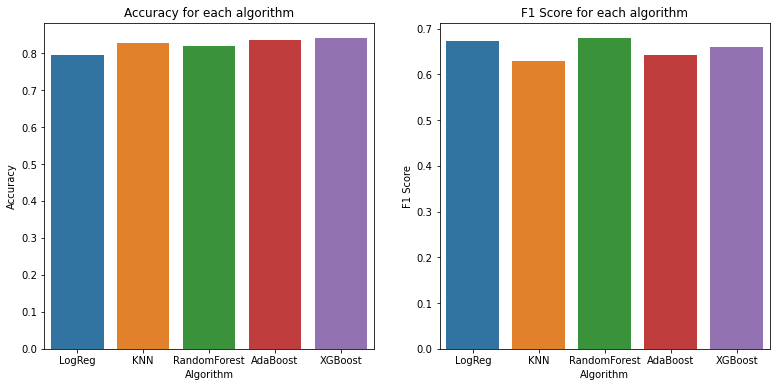

In [26]:
fig, ax = plt.subplots(1,2, figsize=(13,6))
sns.barplot(x=comp['Algorithm'], y=comp['Accuracy'], ax=ax[0])
sns.barplot(x=comp['Algorithm'], y=comp['F1 Score'], ax=ax[1])
ax[0].set_title('Accuracy for each algorithm')
ax[1].set_title('F1 Score for each algorithm')
plt.show()

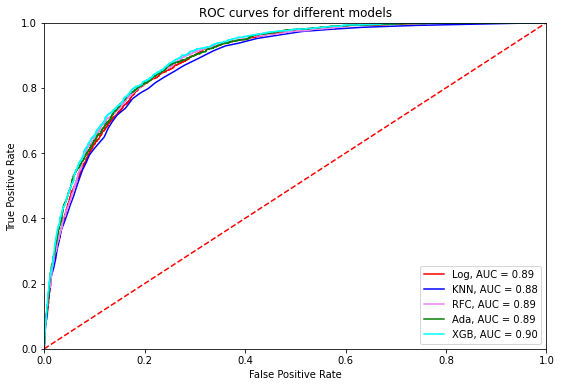

In [29]:
plt.figure(figsize=(9,6))
plt.title('ROC curves for different models')
plt.plot(log_fpr, log_tpr, 'red', label = 'Log, AUC = %0.2f' % log_roc_auc)
plt.plot(knn_fpr, knn_tpr, 'blue', label = 'KNN, AUC = %0.2f' % knn_roc_auc)
plt.plot(rfc_fpr, rfc_tpr, 'violet', label = 'RFC, AUC = %0.2f' % rfc_roc_auc)
plt.plot(ada_fpr, ada_tpr, 'green', label = 'Ada, AUC = %0.2f' % ada_roc_auc)
plt.plot(xgb_fpr, xgb_tpr, 'cyan', label = 'XGB, AUC = %0.2f' % xgb_roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("ROC.jpg")
plt.show()